In [57]:
#deps
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

In [58]:
# questions:
# - what model should be used to determine which fields are most likely to lead to a win
# - how should i analyze the data from both an individual player perspective and a team perspective - one-hot the player_id field
# - how does time play into the data
# - deployment
# - how to deal with nulls 
# - exploratory data analysis/correlation
# - find the difference between deep and machine learning

# read the data


data = pd.read_csv('data/mncs-players.csv')

# immediately drop problematic data
data = data.dropna(subset=['team_id', 'map_name', 'opponent_team_color'])

C:\Users\Corbin\AppData\Local\Temp\ipykernel_26340\1259675275.py:13: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/mncs-players.csv')


In [59]:
# find out where data is missing
missing_data = data.isnull().sum()
print(missing_data[missing_data > 0])

game_id_overtime_game      28074
match_id_win               17586
game_id_win                17586
game_id_win_total          17586
game_id_forfeit_win        35172
overtime_seconds_played    28074
ms_most_forward                1
is_sub_for_team            31052
dtype: int64


In [60]:
# null handling
true_false_cols = ['is_sub_for_team', 'game_id_overtime_game', 'overtime_seconds_played',
                   'match_id_win', 'game_id_win']
for c in true_false_cols:
    if c in data.columns:
        data[c] = data[c].notnull()
data['overtime_seconds_played'] = data['overtime_seconds_played'].fillna(0)

# drop useless columns
useless_columns = ['league_name', 'map_name', 'game_id_total', 'player_name',
                   'player_platform_id', 'team_name', 'opponent_team_name',
                   'team_color', 'opponent_team_color', 'game_id_forfeit_win',
                   'game_id_win_total', 'season_id', 'match_type', 'epoch_processed',
                   'week', 'game_id_win']
for c in useless_columns:
    if c in data.columns:
        data = data.drop(c, axis=1)

In [61]:
# days from Jan 1, 2019, when the league started
# Convert the date column to datetime and make it tz-naive
data['game_date'] = pd.to_datetime(data['game_date']).dt.tz_convert(None)

# Define the date to subtract from
date_to_subtract = pd.to_datetime('2019-01-01')

# Calculate the number of days difference and assign to the date column
data['game_date'] = (data['game_date'] - date_to_subtract).dt.days

In [62]:
# Check for null values
null_like = [np.nan, None, [], {}, 'NaN', 'Null','NULL','None','NA','?','-', '.', '', ' ', '   ']

print("Property | isnull() | null-like")
for c in data.columns:
    string_null = np.array([x in null_like for x in data[c]])
    null_sum = string_null.sum()
    if null_sum > 0:
        print(c, null_sum)

Property | isnull() | null-like


In [63]:
print('sum', data.isna().sum().sum())

sum 1


In [64]:
# found 1 na so we drop it
data = data.dropna()

In [65]:
object_columns = data.dtypes[data.dtypes == 'object'].index
print(object_columns)
for column in object_columns:
    print(f"{column}:\n{data[column].head()}\n")

Index(['league_id', 'match_id', 'game_id', 'player_id', 'player_platform',
       'team_id', 'opponent_team_id'],
      dtype='object')
league_id:
0    5ec9359b8c0dd900074686d3
1    5ec9359b8c0dd900074686d3
2    5ec9359b8c0dd900074686d3
3    5ec9359b8c0dd900074686d3
4    5ec9359b8c0dd900074686d3
Name: league_id, dtype: object

match_id:
0    6209628fa0207820b4ffca16
1    6209628fa0207820b4ffca16
2    6209628fa0207820b4ffca16
3    6209628fa0207820b4ffca16
4    6209628fa0207820b4ffca16
Name: match_id, dtype: object

game_id:
0    621b06d35e639700090d6a47
1    621b06d35e639700090d6a47
2    621b06d35e639700090d6a47
3    621b06d35e639700090d6a45
4    621b06d35e639700090d6a45
Name: game_id, dtype: object

player_id:
0    60eb9cffce9d6800082487b5
1    5ec9358f8c0dd900074685c8
2    62081fc5660ef60009f505df
3    62081fc5660ef60009f505df
4    5ec9358f8c0dd900074685c8
Name: player_id, dtype: object

player_platform:
0    steam
1    steam
2     epic
3     epic
4    steam
Name: player_platform, dty

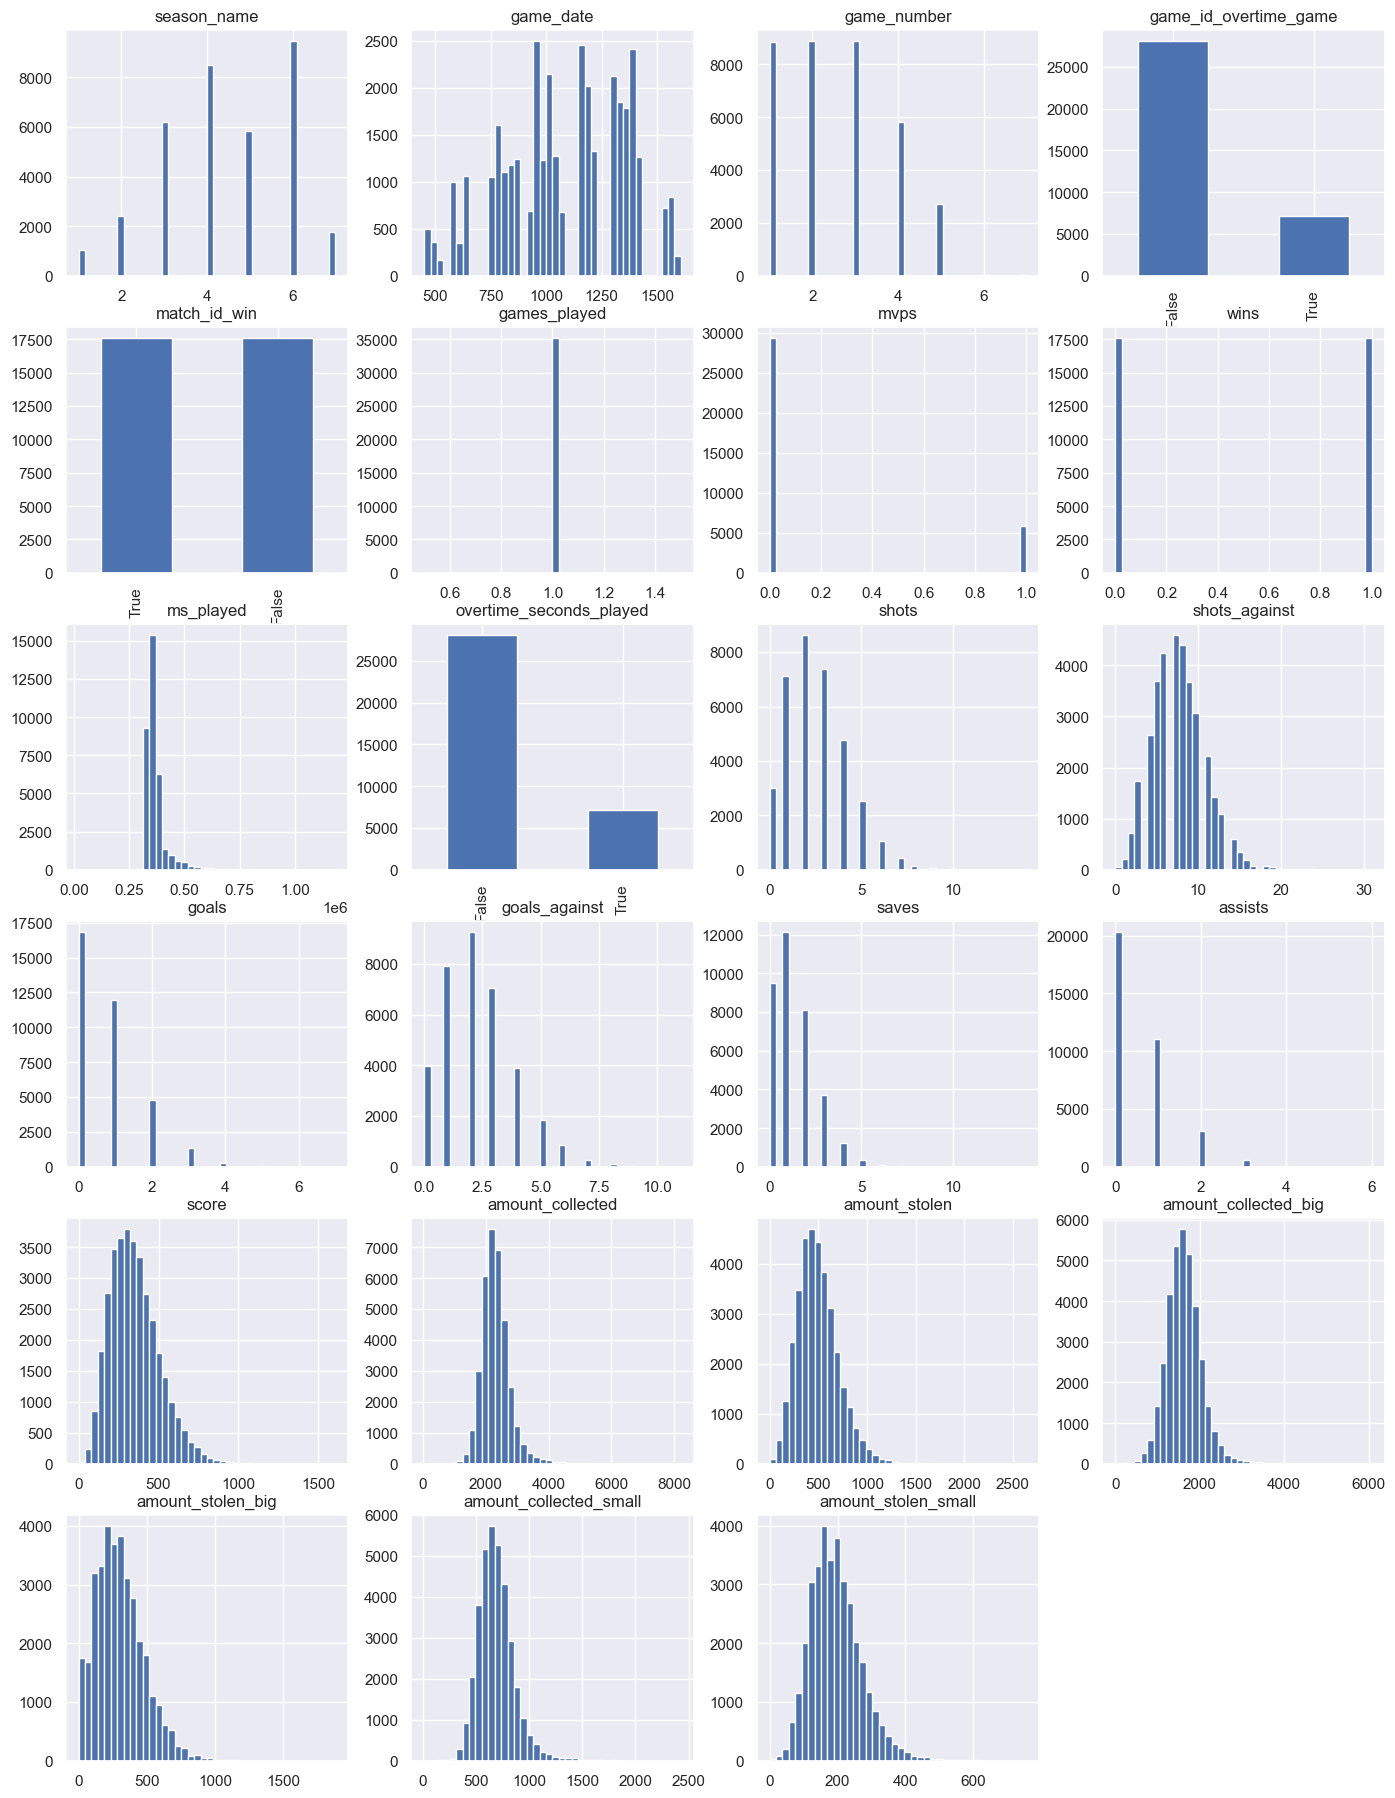

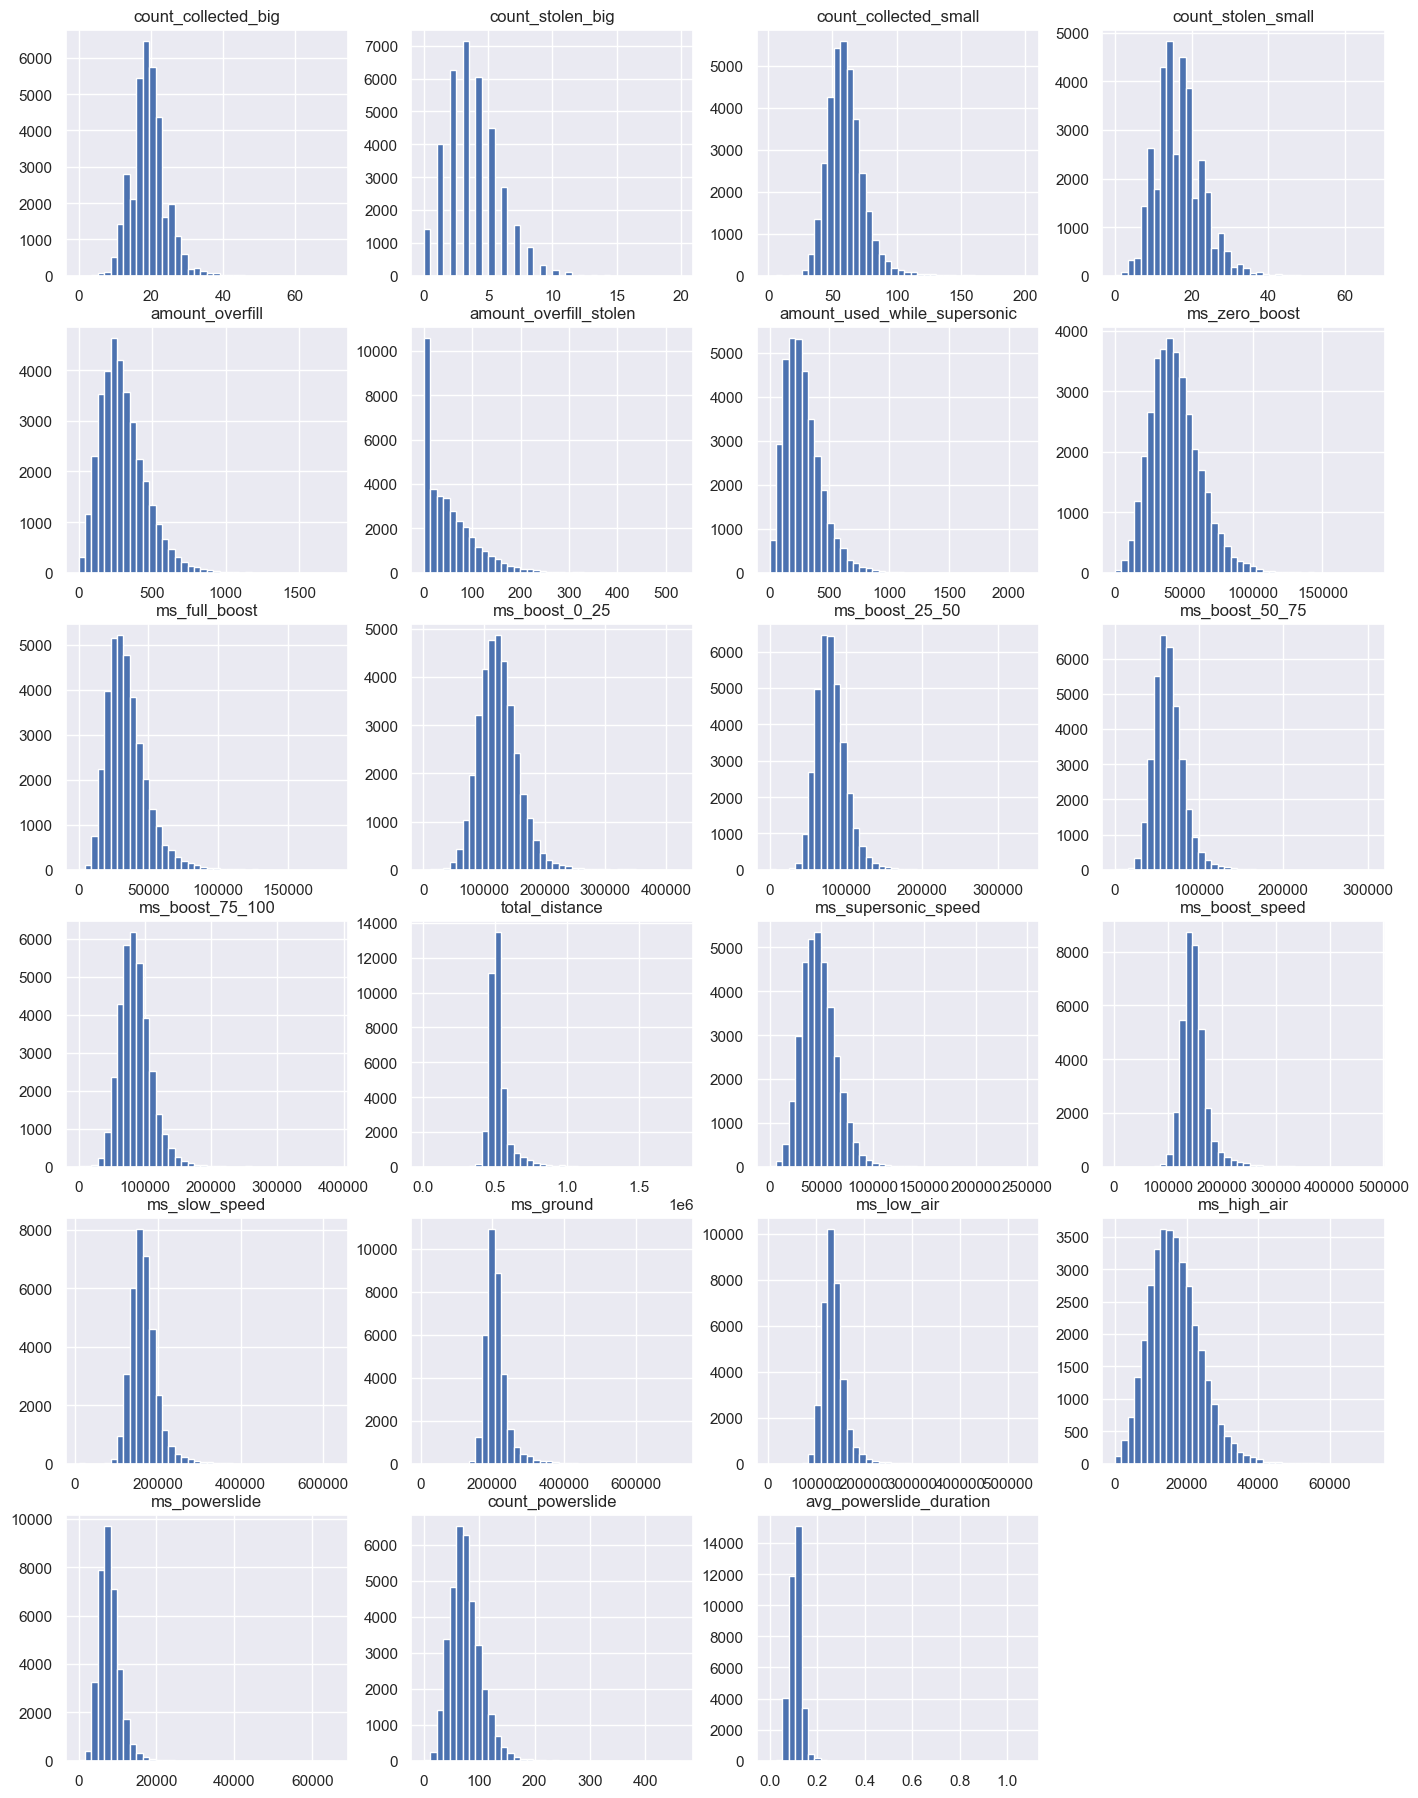

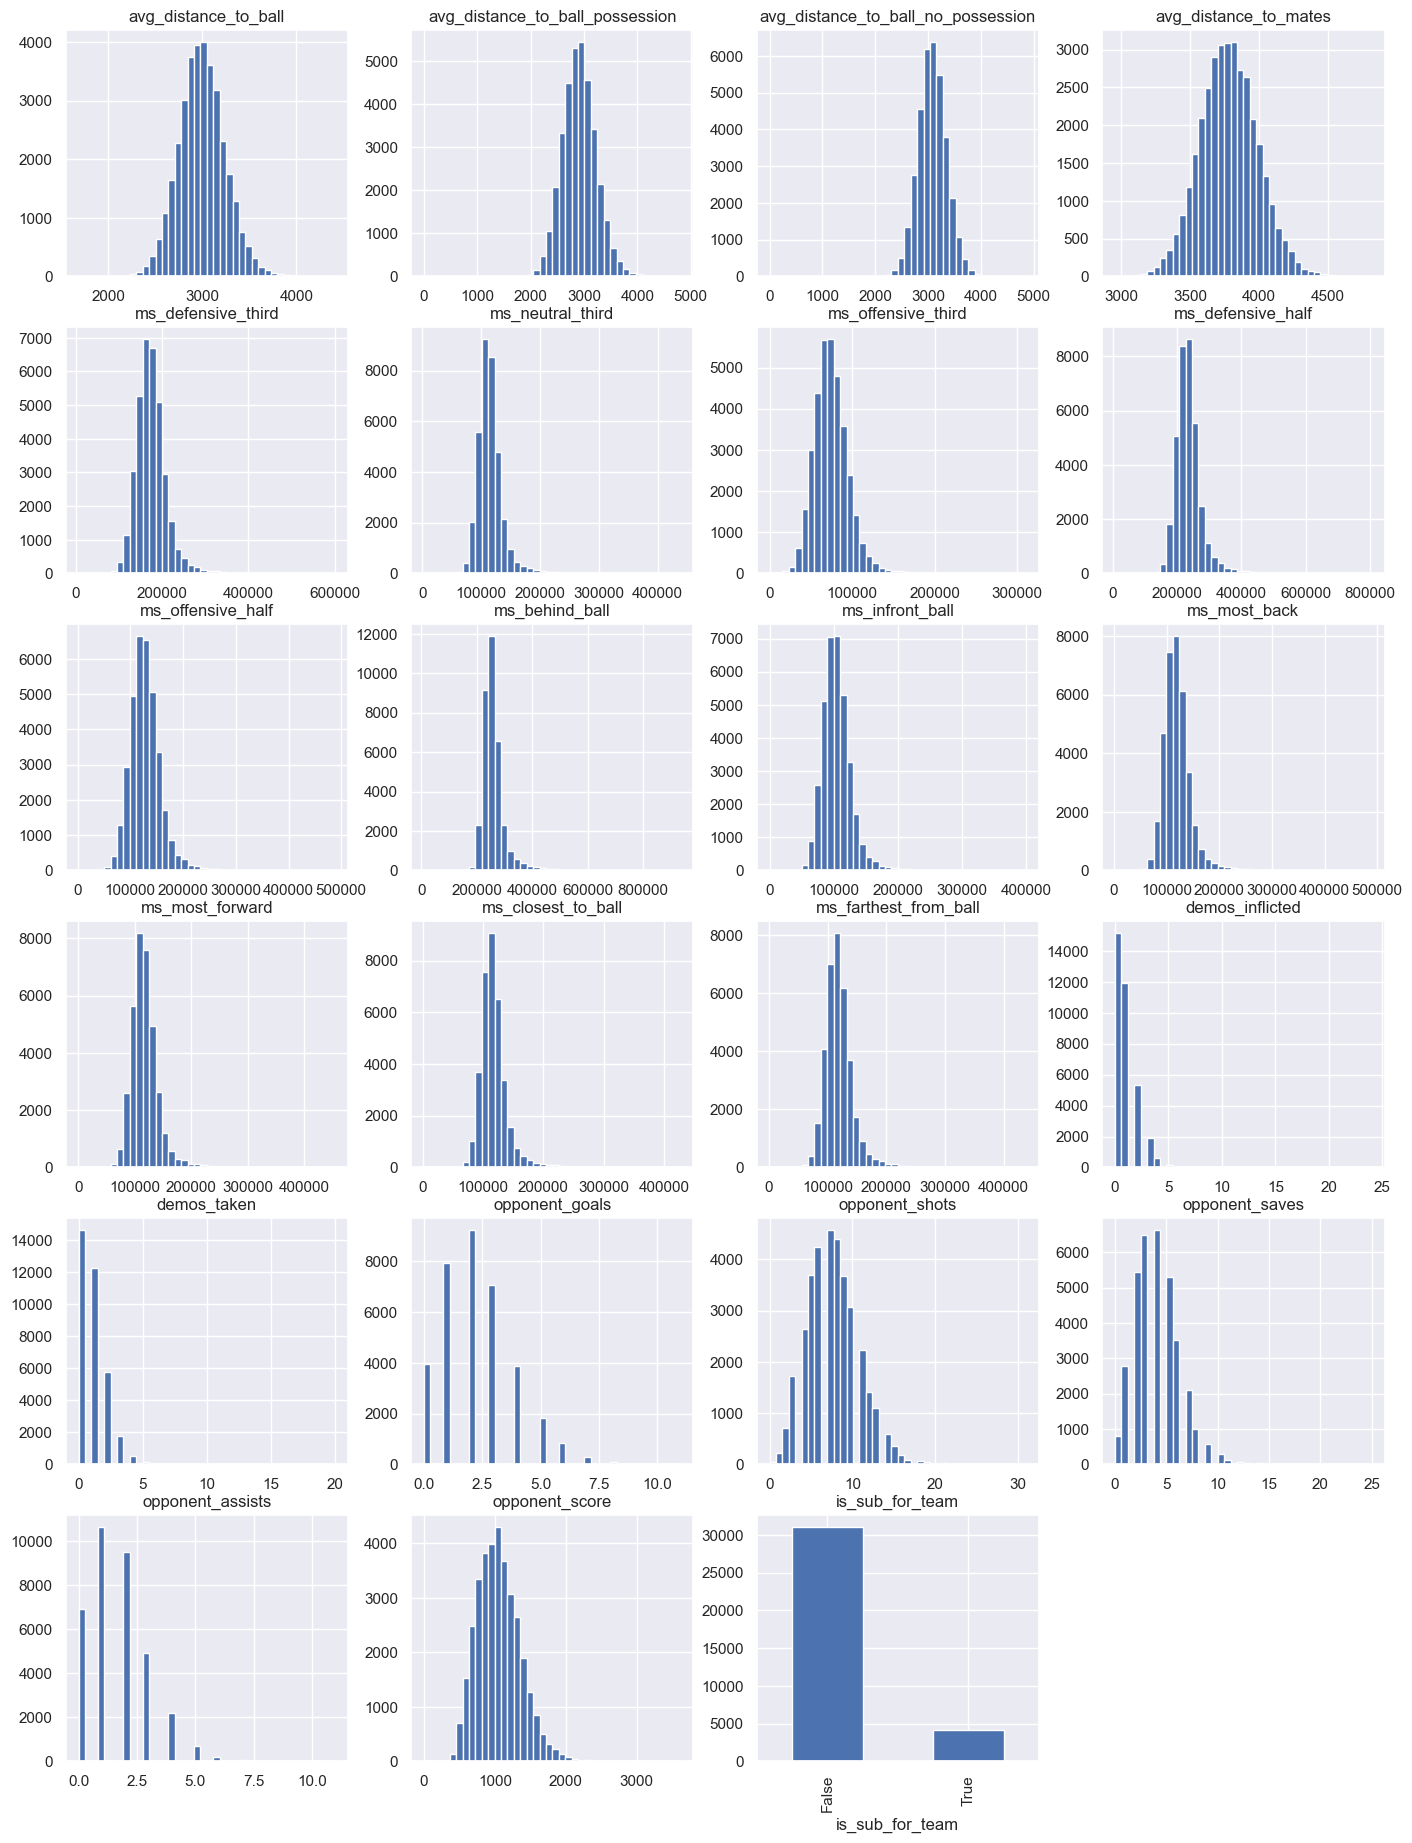

In [66]:
display_df = data.drop(object_columns, axis=1)
n = len(display_df.columns)
n_per_fig = n // 3  # calculate number of columns per figure

# Create three figures
for i in range(3):
    start = i * n_per_fig
    end = (i+1) * n_per_fig if i != 2 else None  # go to end for last figure
    columns = display_df.columns[start:end]
    
    rows = len(columns)//4 + (len(columns)%4 != 0)  # calculate number of rows necessary for 4 columns

    fig, a = plt.subplots(rows, 4, figsize=(14, 3*rows))  # adjust size as necessary
    fig.tight_layout()

    for j, c in enumerate(columns):
        dat = display_df[c]
        ax = a.flat[j]
        if display_df[c].dtype == 'bool':
            display_df[c].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(c)
        else:
            ax.hist(dat, bins=40)
            ax.set_title(c)
        
    # Remove unused subplots
    if len(columns) < rows*4:
        for ax in a.flat[len(columns):]:
            ax.axis('off')

    plt.show()

I noticed that amount_overfill_stolen had an interesting shape, with a large amount of records falling close to zero, so wanted to get a better look

                    league_id                  match_id  season_name   
18   5ec9359b8c0dd900074686d3  6209628fa0207820b4ffca16            5  \
39   600c92f9f87c0c000826a31f  641e1e138ad943849c499f3c            7   
40   600c92f9f87c0c000826a31f  641e1e138ad943849c499f3c            7   
50   600c92f9f87c0c000826a31f  641e1e138ad943849c499f3c            7   
70   600c92f9f87c0c000826a31f  641e1e138ad943849c499f39            7   
80   600c92f9f87c0c000826a31f  641e1e138ad943849c499f41            7   
88   600c92f9f87c0c000826a31f  641e1e138ad943849c499f41            7   
89   600c92f9f87c0c000826a31f  641e1e138ad943849c499f41            7   
112  600c92f9f87c0c000826a31f  641e1e138ad943849c499f44            7   
123  600c92f9f87c0c000826a31f  641e1e138ad943849c499f44            7   

                      game_id  game_date  game_number  game_id_overtime_game   
18   621b06d35e639700090d6a47       1153          4.0                  False  \
39   64262c1784b7f100088aa842       1549       

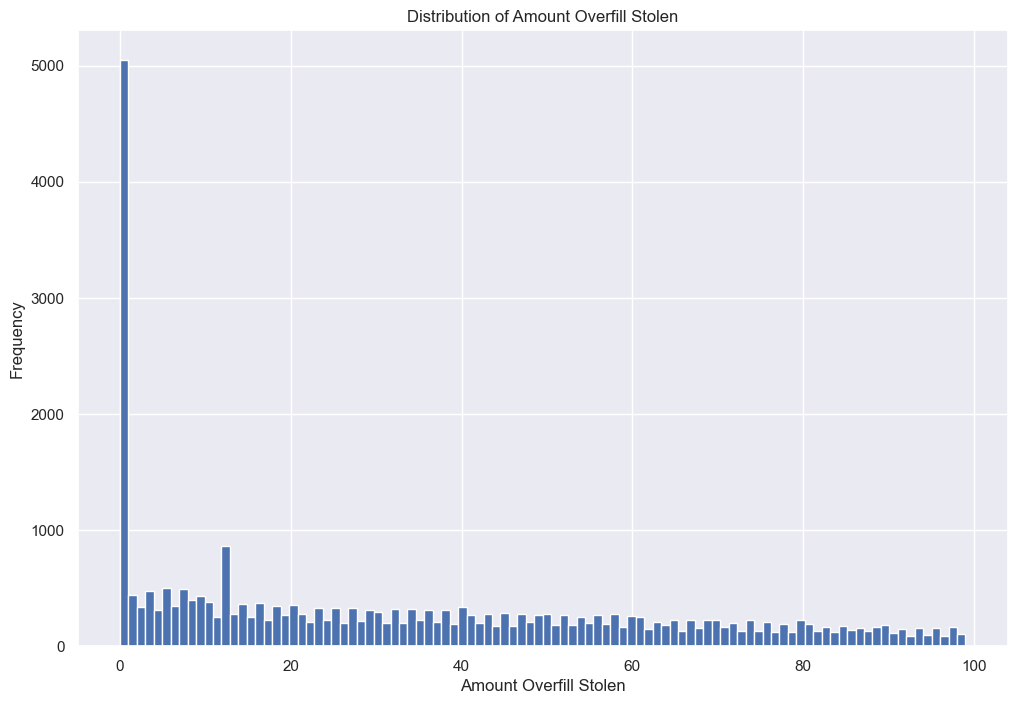

In [67]:
print(data[data['amount_overfill_stolen'] == 0].head(10))


overfill_stolen = data[data['amount_overfill_stolen'] < 100]
plt.figure(figsize=(12,8))  # Adjust the size of the figure as needed
plt.hist(overfill_stolen['amount_overfill_stolen'], bins=100)  # Adjust the number of bins as needed
plt.title('Distribution of Amount Overfill Stolen')
plt.xlabel('Amount Overfill Stolen')
plt.ylabel('Frequency')
plt.show()

295 have amount_overfill_stolen equal to zero in at least one game


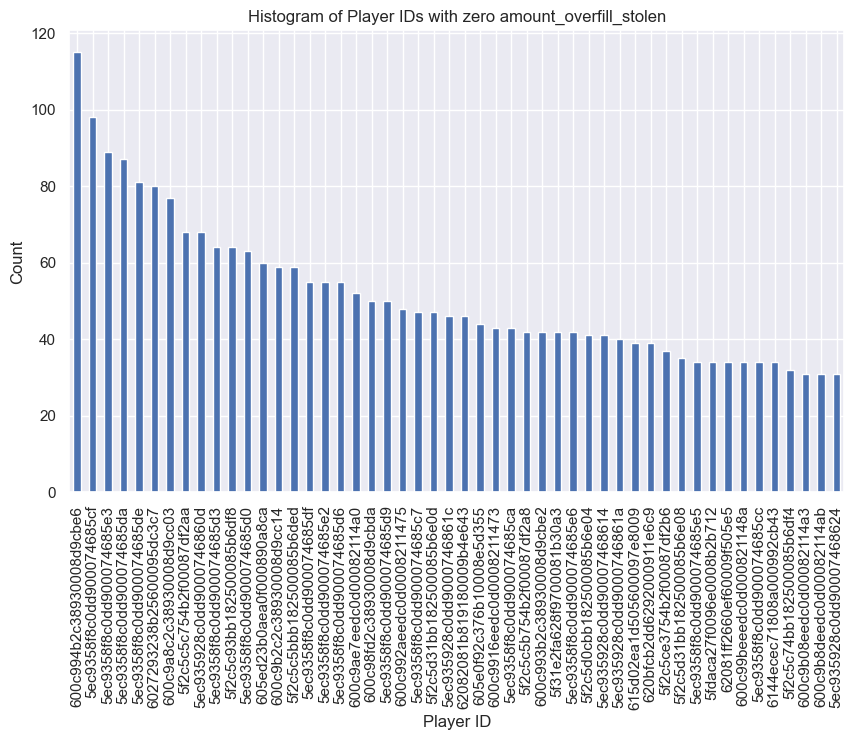

Tero overfills: 47
Prussia overfills: 81
Max overfills 600c994b2c38930008d9cbe6


In [68]:
overfill_stolen_zero = data[data['amount_overfill_stolen'] == 0]

# Count the number of rows for each player_id
player_id_counts = overfill_stolen_zero['player_id'].value_counts()

print(len(player_id_counts), 'have amount_overfill_stolen equal to zero in at least one game')

# Select the top 50 player_id values
top_50_player_ids = player_id_counts[:50]

# Plot a histogram
plt.figure(figsize=(10,6))
top_50_player_ids.plot(kind='bar')
plt.title('Histogram of Player IDs with zero amount_overfill_stolen')
plt.xlabel('Player ID')
plt.ylabel('Count')
plt.show()

print('Tero overfills:', player_id_counts['5ec9358f8c0dd900074685c7'])
print('Prussia overfills:', player_id_counts['5ec9358f8c0dd900074685de'])
print('Max overfills', overfill_stolen_zero['player_id'].value_counts().idxmax())

After thinking about it, this data makes sense because the likelihood of overfilling on opponent boost at all can be relatively low, so it is similar to a bimodal distribution mixed with a normal distribution centered on zero

<Axes: >

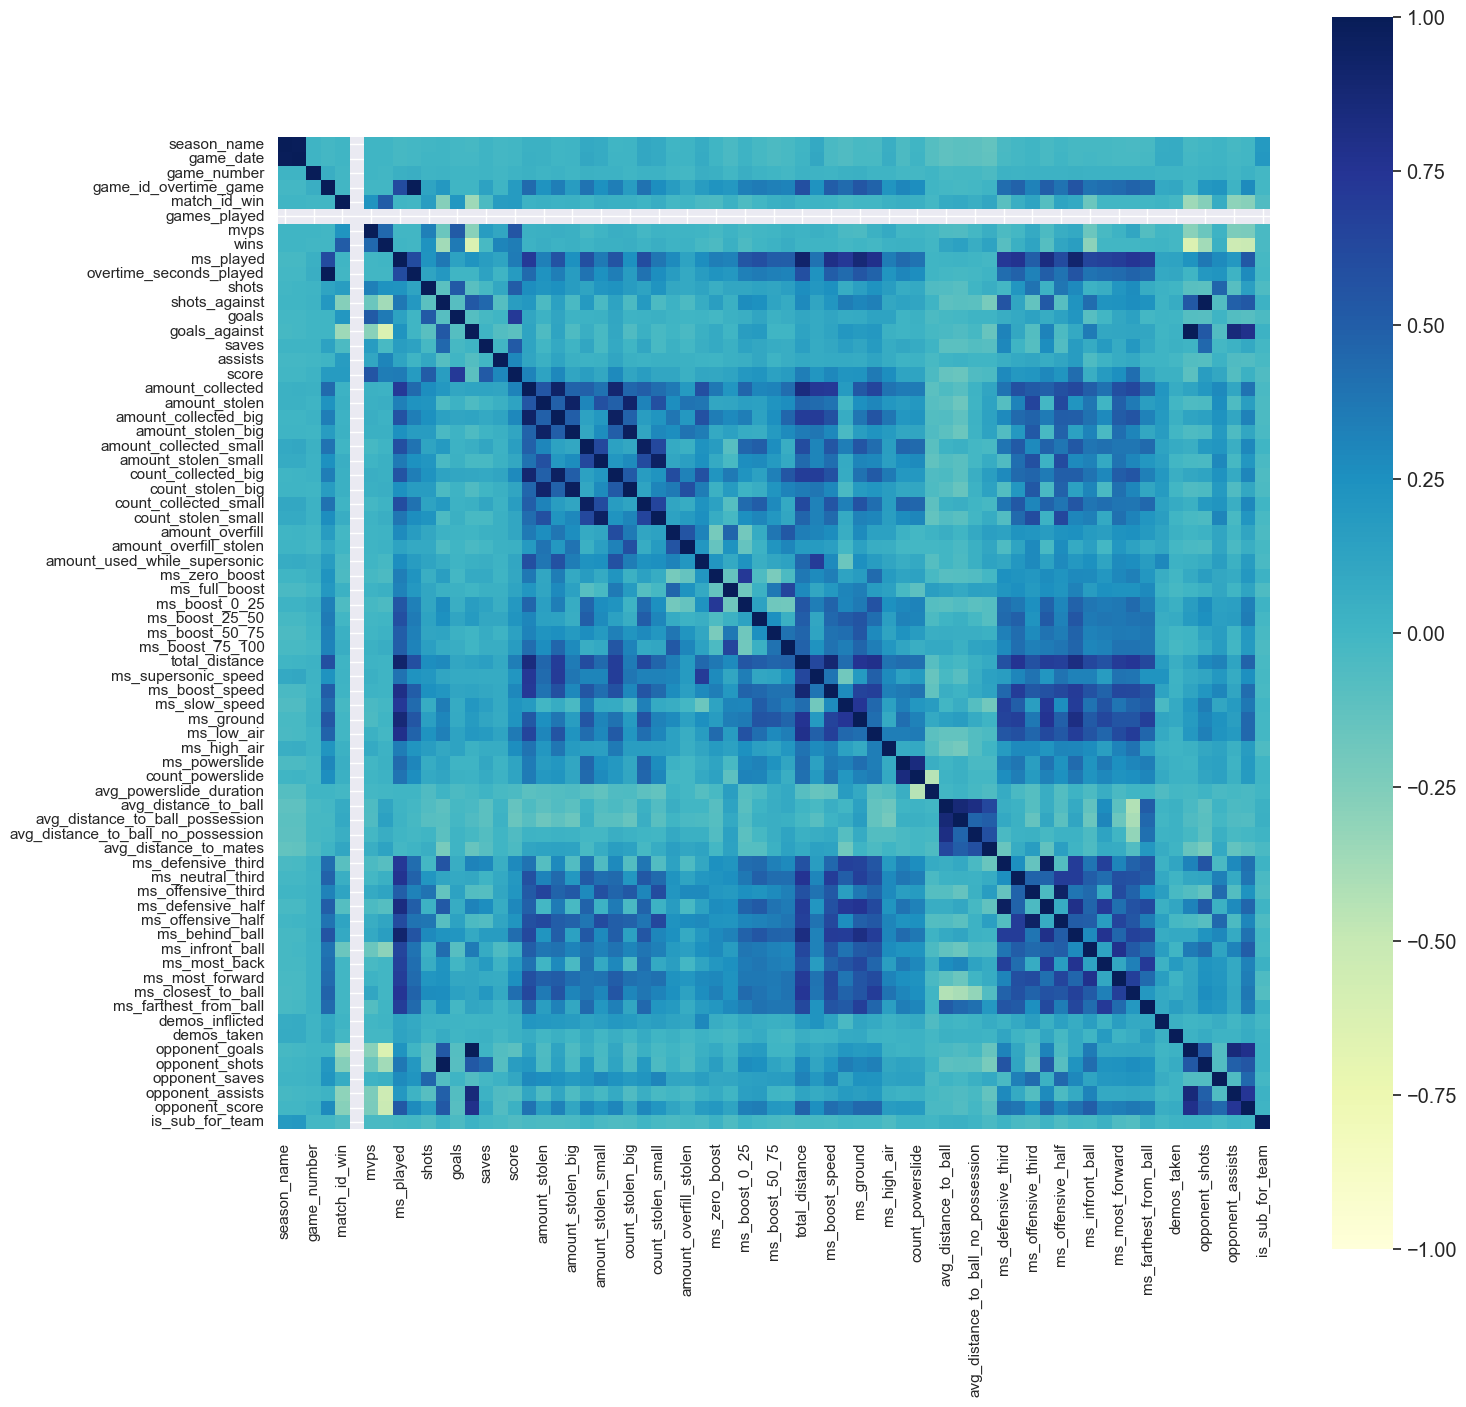

In [69]:
# Look into feature correlation
corr = display_df.corr()
plt.subplots(figsize=(16,16))
sns.set(font_scale=1.3)
sns.heatmap(data=corr, vmin=-1, vmax=1, cmap="YlGnBu", square=True, yticklabels=True)

I want to know if certain correlation paris (such as ms_infront_ball x wins) correlate differently for different players

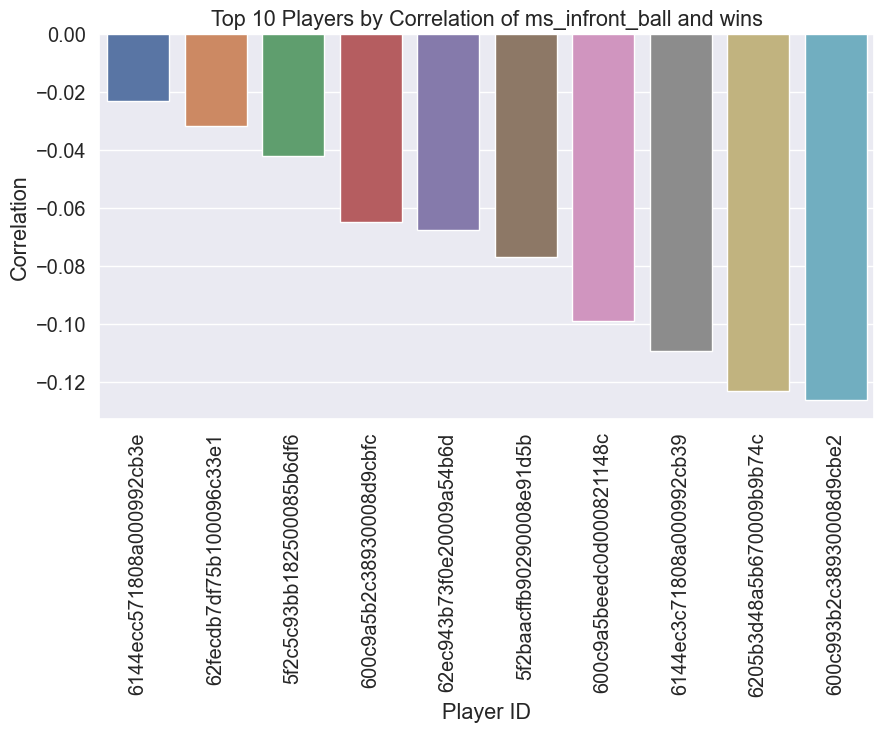

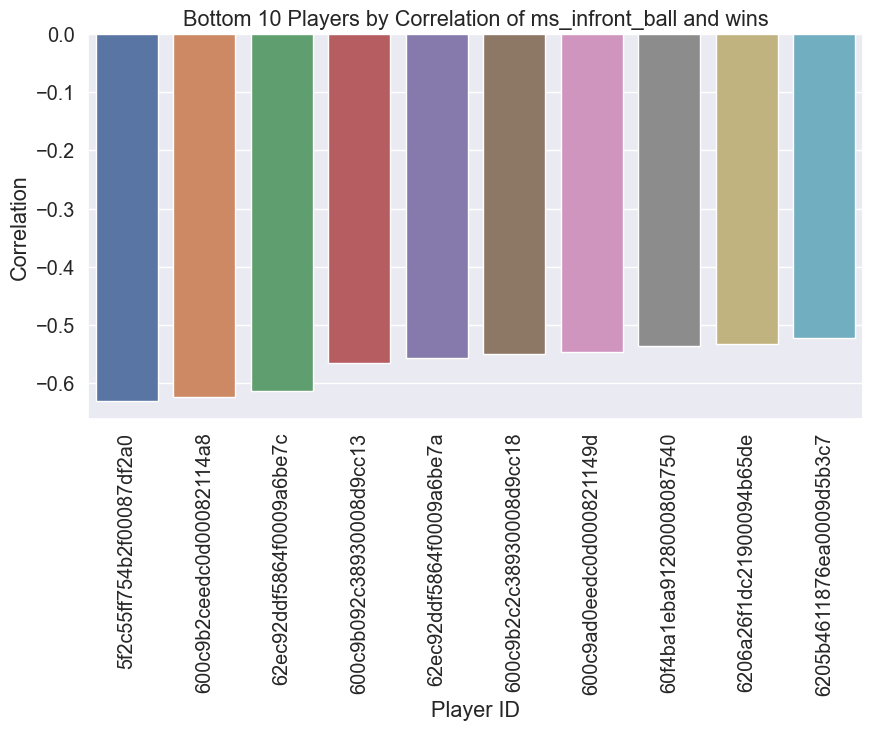

player_id
6144ecc571808a000992cb3e   -0.023225
62fecdb7df75b100096c33e1   -0.031932
5f2c5c93bb182500085b6df6   -0.042225
600c9a5b2c38930008d9cbfc   -0.065002
62ec943b73f0e20009a54b6d   -0.067569
5f2baacffb90290008e91d5b   -0.077125
600c9a5beedc0d000821148c   -0.098951
6144ec3c71808a000992cb39   -0.109497
6205b3d48a5b670009b9b74c   -0.123280
600c993b2c38930008d9cbe2   -0.126494
dtype: float64


In [70]:
# player_correlations = {}

# for player in data['player_id'].unique():
#     player_data = data[data['player_id'] == player]
#     correlation = player_data['ms_infront_ball'].corr(player_data['wins'])
#     player_correlations[player] = correlation

# # Transform dictionary to DataFrame
# corr_df = pd.DataFrame(list(player_correlations.items()), columns=['player_id', 'correlation'])

# # Sort by absolute correlation value and take top 50
# top_correlations = corr_df.reindex(corr_df.correlation.abs().sort_values(ascending=False).index).head(50)

# plt.figure(figsize=(20,10))
# sns.barplot(x='player_id', y='correlation', data=top_correlations)
# plt.xticks(rotation=90)
# plt.show()
# print(top_correlations)

# Filter player_ids with more than 30 records
players_with_enough_data = data.groupby('player_id').filter(lambda x: len(x) > 30)

# Calculate correlations for each player
player_correlations = players_with_enough_data.groupby('player_id').apply(lambda x: x['ms_infront_ball'].corr(x['wins']))

# Get top 10 and bottom 10 players by correlation
top_10_players = player_correlations.nlargest(10)
bottom_10_players = player_correlations.nsmallest(10)

# Plot top 10 players
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_players.index, y=top_10_players.values)
plt.title('Top 10 Players by Correlation of ms_infront_ball and wins')
plt.xlabel('Player ID')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

# Plot bottom 10 players
plt.figure(figsize=(10,5))
sns.barplot(x=bottom_10_players.index, y=bottom_10_players.values)
plt.title('Bottom 10 Players by Correlation of ms_infront_ball and wins')
plt.xlabel('Player ID')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

print(top_10_players)

In [71]:
# one hot the object columns
x = pd.get_dummies(data, columns=object_columns)
y = data['wins']

In [72]:
# Data split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1, test_size=0.2)
# Normalize features by scaling
sc_x = StandardScaler()
x_trainscaled = sc_x.fit_transform(x_train)
x_testscaled = sc_x.transform(x_test)

print(x_trainscaled[:3])
print(y_train[:6])

[[ 1.04647439  1.19877099  0.34201595 ... -0.06969321 -0.06995021
  -0.07247112]
 [-0.30139823 -0.46391819  0.34201595 ... -0.06969321 -0.06995021
  -0.07247112]
 [ 0.37253808  0.35643946  1.14099974 ... -0.06969321 -0.06995021
  -0.07247112]]
6783     1
23940    0
11219    0
33627    1
26763    1
7157     0
Name: wins, dtype: int64


In [73]:
# Multi-Layer Perceptron set-up and training
clf = MLPClassifier( hidden_layer_sizes=(128,64,32), max_iter=400)
clf.fit(x_trainscaled, y_train)
y_pred = clf.predict(x_testscaled)
print(clf.score(x_testscaled, y_test))

0.9846481876332622
